In [39]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import keras
import tensorflow
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk import tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers as L
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenhi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
data = pd.read_csv('./data/data.csv',encoding='latin-1')

In [41]:
data.head()

,S.No.,Review,Rating
0,1,nice hotel expensive parking got good deal sta...,4
1,2,ok nothing special charge diamond member hilto...,2
2,3,nice rooms not 4* experience hotel monaco seat...,3
3,4,unique \tgreat stay \twonderful time hotel mon...,5
4,5,great stay great stay \twent seahawk game awes...,5


# 1. Sentiment Annotation

To make opinions hidden in a review visible to machines --> assign sentiment labels which are positive, neutral or negative to phrases.

In [42]:
analyzer = SentimentIntensityAnalyzer()
def compound_score(txt):
    return analyzer.polarity_scores(txt)["compound"]

## Sentiments
def sentiment(score):
    emotion = ""
    if score >= 0.5:
        emotion = "Positive"
    elif score <= -0.5:
        emotion = "Negative"
    else:
        emotion = "Neutral"
    return emotion

Applying functions: 
    Creating the Sentiment_Score that presents for a normalized score of sum_s and sum_s is the sum of valence computed based on some heuristics and a sentiment lexicion (Sentiment Intensity)
    

In [43]:
polarity_scores = data["Review"].astype("str").apply(compound_score)
data["Sentiment_Score"] = polarity_scores

In [44]:
data["Sentiment"] = data["Sentiment_Score"].apply(sentiment)

In [45]:
data.to_csv("rating-sentiments.csv",index=False)
data.Sentiment.value_counts()

Positive    18321
Negative     1093
Neutral      1077
Name: Sentiment, dtype: int64

In [46]:
hotel=pd.read_csv('rating-sentiments.csv')
hotel.head()

,S.No.,Review,Rating,Sentiment_Score,Sentiment
0,1,nice hotel expensive parking got good deal sta...,4,0.9626,Positive
1,2,ok nothing special charge diamond member hilto...,2,0.9870,Positive
2,3,nice rooms not 4* experience hotel monaco seat...,3,0.9852,Positive
3,4,unique \tgreat stay \twonderful time hotel mon...,5,0.9920,Positive
4,5,great stay great stay \twent seahawk game awes...,5,0.9870,Positive


# 2. Data Exploration

In [47]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   S.No.            20491 non-null  int64  
 1   Review           20491 non-null  object 
 2   Rating           20491 non-null  int64  
 3   Sentiment_Score  20491 non-null  float64
 4   Sentiment        20491 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 800.6+ KB


In [48]:
hotel.describe()

,S.No.,Rating,Sentiment_Score
count,20491.000000,20491.000000,20491.000000
mean,10246.000000,3.952223,0.809721
std,5915.386519,1.233030,0.445757
min,1.000000,1.000000,-0.997600
25%,5123.500000,3.000000,0.921600
50%,10246.000000,4.000000,0.974400
75%,15368.500000,5.000000,0.989000
max,20491.000000,5.000000,0.999900


Histograms are showing that the results are skewed to the right. Positive reviews and high ratings are the majority of the data

array([[<AxesSubplot:title={'center':'S.No.'}>,
        <AxesSubplot:title={'center':'Rating'}>],
       [<AxesSubplot:title={'center':'Sentiment_Score'}>, <AxesSubplot:>]],
      dtype=object)

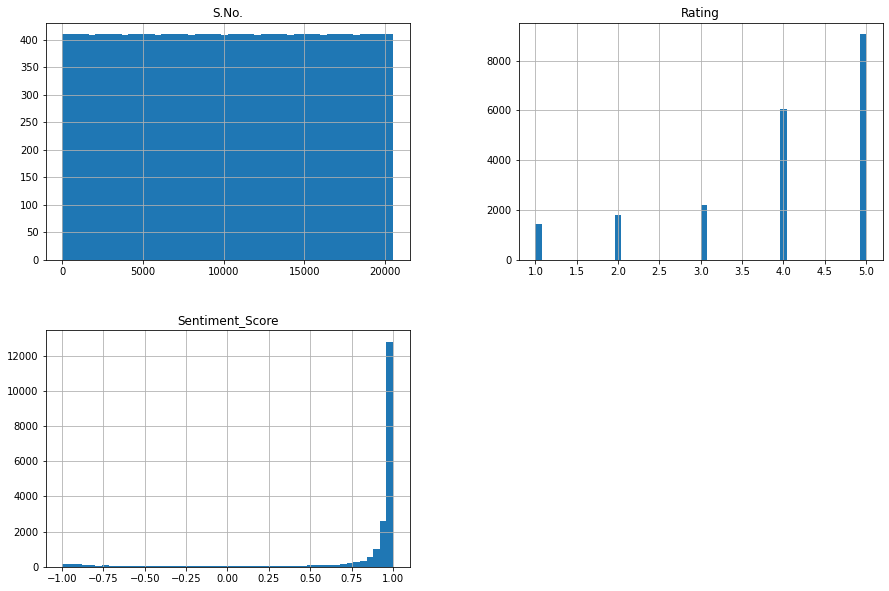

In [49]:
hotel.hist(bins=50,figsize=(15,10))

# 3. Creating the test set

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(hotel, hotel["Sentiment"]):
 strat_train_set = hotel.loc[train_index]
 strat_test_set = hotel.loc[test_index]

In [51]:
strat_test_set["Sentiment"].value_counts() 

Positive    3665
Negative     219
Neutral      215
Name: Sentiment, dtype: int64

In [52]:
for set_ in (strat_train_set, strat_test_set):
 set_.drop("Rating", axis=1, inplace=True)

In [53]:
hotel = strat_train_set.copy()

In [54]:
hotel.describe()

,S.No.,Sentiment_Score
count,16392.000000,16392.000000
mean,10234.984810,0.810251
std,5904.968479,0.444696
min,1.000000,-0.997600
25%,5119.750000,0.922075
50%,10205.500000,0.974700
75%,15346.250000,0.989200
max,20491.000000,0.999900


# 4. Data Visualization

#### Positive,  Negative, and Neutral Reviews.

Before beginning the data exploration, I conducted a sentiment analysis in order to make opinions hidden in a review visible to machines we assigned sentiment labels which are positive, neutral, or negative. The end result was overwhelmingly positive with about 18,000 positive reviews with the rest being negative or neutral.

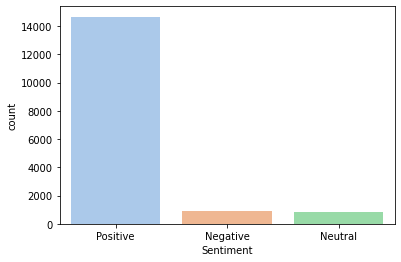

In [55]:
sns.countplot(data=hotel,x="Sentiment",palette="pastel");

#### Positive, Negative, and Neutral Reviews based on Rating

It is interesting that a one star rating has ⅔ of its reviews as neutral to positive sentiment, but it is no surprise that the five star ratings have almost all positive sentiments. 

In [56]:
Viz_1 = data[['Rating','Sentiment']].value_counts().rename_axis(['Rating','Sentiment']).reset_index(name='counts')

fig = px.bar(x=Viz_1.Rating, y=Viz_1.counts, color=Viz_1.Sentiment,color_discrete_sequence=px.colors.qualitative.Pastel,
             title="Positive, Negative, and Neutral Reviews based on Rating",
             labels={'x':'Ratings','y':'Total Number'})
fig.show()

#### The distribution of different ratings

In [57]:
Viz_2 = data['Rating'].value_counts().rename_axis(['Rating']).reset_index(name='counts')
fig_pie = px.pie(values=Viz_2.counts, names=Viz_2.Rating, 
                 title='Rating Distribution of the data',
                 color_discrete_sequence=px.colors.qualitative.Pastel)
fig_pie.show()

# 5. Text Cleaning and Text preprocess

Raw reviews contain meaningless words that can affect model accuracy. I need to clean them up.

### Removing noise

In [58]:
hotel['Review'] = hotel['Review'].str.replace('\d+', '')
hotel['Review'] = hotel['Review'].str.replace('[*-.@&#\/|!%]', '')

<ipython-input-58-9875192f103d>:1: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-58-9875192f103d>:2: FutureWarning:

The default value of regex will change from True to False in a future version.



I decided to predict Sentiment based on Reviews. So I decided to drop "Neutral" reviews in our dataset for the binary classication problem and tokenizing all the words.

In [59]:
hotel = hotel[hotel['Sentiment'] != 'Neutral']

In [60]:
hotel["Sentiment"].value_counts()

Positive    14656
Negative      874
Name: Sentiment, dtype: int64

### Tokenizer

Tokenizing all the words in the text to break down the words/ sentences of a text into small parts called tokens. Reference: https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/

In [61]:
X = hotel["Review"].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [62]:
encoded_docs = tokenizer.texts_to_sequences(X)

max_length = max([len(x) for x in X])
vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("max length of sentence: {}".format(max_length))

Vocabulary size: 64171
max length of sentence: 13342


In [63]:
X = pad_sequences(encoded_docs, maxlen=200) #Pads sequences to the same length

In [64]:
y = hotel.Sentiment.factorize()
y

(array([0, 0, 1, ..., 0, 1, 0], dtype=int64),
 Index(['Positive', 'Negative'], dtype='object'))

# 6. Training

In [65]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           2053472   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 2,070,123
Trainable params: 2,070,123
Non-trainable params: 0
_________________________________________________________________
None


Model visualization

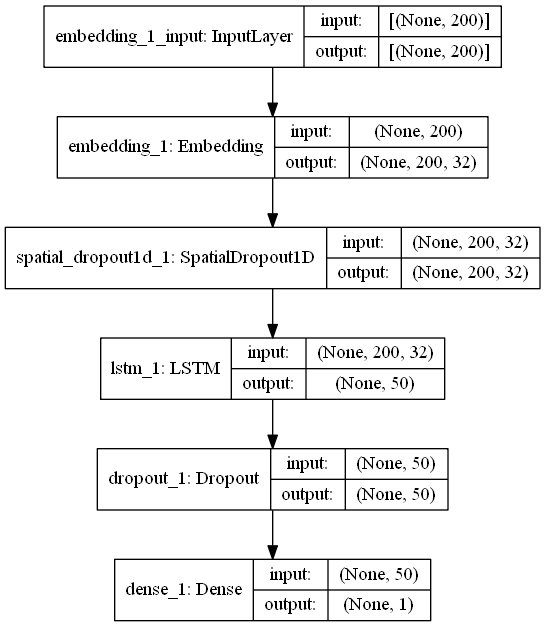

In [66]:
plot_model(model,to_file="model_plot.png",show_shapes=True, show_layer_names = True)

In [67]:
history = model.fit(X,y[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
389/389 [==============================] - 56s 139ms/step - loss: 0.2141 - accuracy: 0.9420 - val_loss: 0.1656 - val_accuracy: 0.9520
Epoch 2/5
389/389 [==============================] - 52s 133ms/step - loss: 0.0974 - accuracy: 0.9664 - val_loss: 0.1226 - val_accuracy: 0.9552
Epoch 3/5
389/389 [==============================] - 71s 182ms/step - loss: 0.0655 - accuracy: 0.9774 - val_loss: 0.1311 - val_accuracy: 0.9639
Epoch 4/5
389/389 [==============================] - 70s 179ms/step - loss: 0.0361 - accuracy: 0.9890 - val_loss: 0.1428 - val_accuracy: 0.9656
Epoch 5/5
389/389 [==============================] - 72s 185ms/step - loss: 0.0225 - accuracy: 0.9934 - val_loss: 0.1600 - val_accuracy: 0.9614


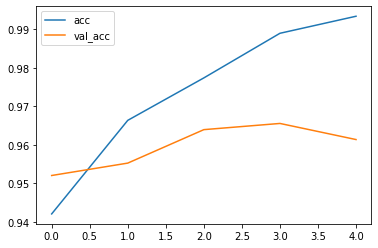

<Figure size 432x288 with 0 Axes>

In [68]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

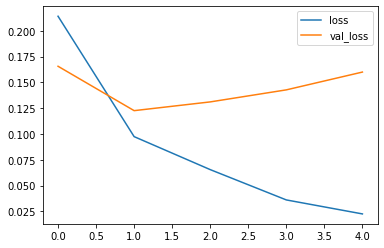

<Figure size 432x288 with 0 Axes>

In [69]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plt.jpg")

### Test some reviews

In [70]:
def predict_sentiment(Review):
    tw = tokenizer.texts_to_sequences([Review])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", y[1][prediction])
test_sentence1 = "I enjoyed my vacation at your hotel"
predict_sentiment(test_sentence1)
test_sentence2 = "I do not like that hotel!"
predict_sentiment(test_sentence2)

Predicted label:  Positive
Predicted label:  Negative


In [71]:
model.save("Hotel_Sentiment_Analysis.h5")

# 7. Testing Saved model

In [72]:
new_model = tf.keras.models.load_model("Hotel_Sentiment_Analysis.h5")

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           2053472   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 2,070,123
Trainable params: 2,070,123
Non-trainable params: 0
_________________________________________________________________


# Note: 
    Installed packages:
        - flashtext: pip install flashtext
        - VADER sentiment: pip install vaderSentiment 